# Dialogic Reading Dataset EDA

This notebook explores the structure, composition, and type distribution of our dialogic reading (DR) question dataset to inform the design of ECO (Equivalence Coverage Optimization) experiments.

**What we need to know:**
- How many questions per page? (determines equivalence set sizes for ECO)
- What types of questions dominate? (reveals pre-existing bias the model will amplify)
- How does the synthetic data distribution compare to expert-written ground truth? (quantifies the gap ECO needs to close)
- Which pages have enough diversity to serve as meaningful training signal?

**Data sources:**
- **Synthetic questions** (~95k): Generated by GPT-o3 with a prompt that includes instructions to keep generating until it ran out of non-redundant ideas for each page.
- **Gold questions** (~4.5k): Human-written/verified questions, including ~1,169 across 3 fully-annotated books (33 pages) that serve as our ground truth for "complete" question coverage.

The dataset is stored as JSONL with one question per line. Each entry has: `book`, `page_id`, `question`, `quality` (1=gold, 0=synthetic), `source`, `image_path`, `page_text`, and `weight`.

## 1. Load Data and Confirm Structure
First, we load the data and confirm that it contains those fields that we just mentioned.

In [39]:
import json, re
from collections import Counter, defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 100

# ── Load data ──
DATA_PATH = 'train.jsonl'

data = []
with open(DATA_PATH) as f:
    for line in f:
        line = line.strip()
        if line:
            data.append(json.loads(line))

print(f"Loaded {len(data):,} questions")
print(f"Sample keys: {list(data[0].keys())}")
data[10]

Loaded 110,412 questions
Sample keys: ['book', 'page_id', 'question', 'quality', 'page_text', 'weight', 'image_path', 'source']


{'book': 'Early Concepts Letters 9781486701360',
 'page_id': 'dig-pbb-0808-0130_early_concepts-letters_9781486701360_09',
 'question': 'If you could add one more animal to that pen, what would you pick and why?',
 'quality': 0,
 'page_text': '9 Yy yo-yo Zz zebra\\p(Image caption: The image is divided into two sections. On the left, a child with curly hair is focused on playing with a colorful yo-yo, wearing a red jacket with white stripes. The background is a blurred green outdoor setting. On the right, a young child is standing at a wooden fence, looking at a zebra and a brown horse in an enclosure. The child is wearing a red shirt and jeans. The enclosure has a dirt ground and some grass, with a metal wire fence separating the animals from the viewer.)',
 'weight': 1.0,
 'image_path': 'images/dig-pbb-0808-0130_early_concepts-letters_9781486701360/page_009.jpg',
 'source': 'synthetic'}

In [40]:
books = set(d['book'] for d in data)
pages = set(d['page_id'] for d in data)
sources = Counter(d.get('source', 'unknown') for d in data)
qualities = Counter(d.get('quality', -1) for d in data)

print(f"Books:    {len(books):,}")
print(f"Pages:    {len(pages):,}")
print(f"Sources:  {dict(sources)}")
print(f"Quality:  {dict(qualities)}")

Books:    178
Pages:    2,060
Sources:  {'synthetic': 106334, 'gold': 4078}
Quality:  {0: 106334, 1: 4078}


## 2. Classify Questions By Type

### The taxonomy

Our question types come from the dialogic reading pedagogical framework - questions meant for use in reading sessions where an adult asks a child questions about a book to promote development and engagement.

In developing the prompt to generate questions and a framework for question types, we defined 7 categories that were designed to be both pedagogically meaningful and distinguishable enough for rule-based classification:

| Type | What it asks | Key signature | Example |
|------|-------------|--------------|---------|
| **Concrete** | Observable aspects of illustrations | "What do you see...", "How many..." | *"What is the dog wearing?"* |
| **Mental State** | Character feelings, thoughts, motivations | "How does X feel...", "What is X thinking..." | *"How do you think Bear feels about losing his ball?"* |
| **Imaginative Personal** | Child imagines being in character's situation | Contains **"would you"** | *"How would you feel if you lost your favorite toy?"* |
| **Reflective Personal** | Three-part: child's own experience + elaborate + alternative | **"Have you ever... If yes... If no..."** | *"Have you ever lost something special? If yes, tell me about it. If no, is there something you'd hate to lose?"* |
| **Causal** | Why/how about events or world knowledge | "Why might...", "What caused..." | *"How do you think the ball disappeared?"* |
| **Prediction** | What happens next, what will character do | "What do you think X will...", "What happens next..." | *"Where do you think Bear will look next?"* |
| **Definitional** | Three-part: word meaning + elaborate + define | **"Do you know what X means? If yes... If no..."** | *"Do you know what persistent means? If yes, can you use it? If no, it means..."* |

### Why these categories matter

The core task at hand is to be able to create a **set** of high quality dialogic reading questions for a given page of a children's book. An ideal high quality set contains a *mix* of question types for each page - some that ground the child in the illustration (Concrete), some that develop empathy (Mental State), some that connect to the child's life (Personal types), some that build vocabulary (Definitional). If SFT causes the model to collapse toward generating only Causal or only Prediction questions (the "easy" types), the pedagogical value is destroyed *even if each individual question is high quality*.

In this real-world example, it's impossible to define one question for a page as *better* or *more ideal*. Rather, there is a theoretical set of questions, all equally valid and of equal quality which, over several generations, the model should cover completely. This makes the DR case an ideal for work in mode collapse prevention.

### The regex classifier

In order to understand when these broad types are lost, we want to classify our dataset into these question types. We do not have labels for *either* the synthetic or gold questions. So, we endeavor to develop a labeling system for our dataset.

For this, we use a rule-based classifier rather than an LLM because we need fast, deterministic classification during training experiments (we will run this at every eval checkpoint across multiple conditions). This is likely an ok approximate, because the classifier exploits the strong structural signatures of each type:

- **Definitional** and **Reflective Personal** have unmistakable three-part "If yes.../If no..." structures
- **Imaginative Personal** nearly always contains "would you"
- **Prediction** uses future-oriented framing ("what do you think X will...")
- **Mental State** references emotions or cognitive states
- **Causal** typically starts with "why" (after excluding emotion-related "why" questions)

Below, we define our classify function that looks for these common or unique question patterns.

In [41]:
def classify_question(q):
    ql = q.lower().strip()

    # Definitional
    if re.search(r'do you know what', ql) and ('if yes' in ql or 'if no' in ql):
        return 'Definitional'
    if re.search(r'do you know what .{0,30}means?', ql):
        return 'Definitional'
    if re.search(r'what (do you think |does )it mean', ql):
        return 'Definitional'
    if re.search(r'what does .{1,30} mean', ql):
        return 'Definitional'

    # Reflective Personal
    if 'if yes' in ql and 'if no' in ql:
        return 'Reflective Personal'
    if re.search(r'have you ever\b', ql):
        return 'Reflective Personal'
    if re.search(r'(tell|talk) me about a time', ql):
        return 'Reflective Personal'
    if re.search(r'can you (tell|talk|share)', ql) and not re.search(r'would you', ql):
        return 'Reflective Personal'
    if re.search(r'what do you (like|love|enjoy) to\b', ql):
        return 'Reflective Personal'
    if re.search(r'do you (like|love|enjoy) to\b', ql):
        return 'Reflective Personal'
    if re.search(r'what do you know about\b', ql):
        return 'Reflective Personal'
    if re.search(r'what is your fav', ql):
        return 'Reflective Personal'

    # Imaginative Personal
    if re.search(r'\bwould you\b', ql):
        return 'Imaginative Personal'
    if re.search(r'\bif you (could|were|had)\b', ql):
        return 'Imaginative Personal'
    if re.search(r'how would you feel', ql):
        return 'Imaginative Personal'
    if re.search(r'how do you think it would feel', ql):
        return 'Imaginative Personal'
    if re.search(r'how .{0,15}would it feel', ql):
        return 'Imaginative Personal'

    # Mental State
    if re.search(r'what .{0,30}(thinking|dreaming|hoping|wishing|feeling|imagining)', ql):
        return 'Mental State'
    if re.search(r'how (do|does|might|could|will|would) .{0,40}feel', ql):
        return 'Mental State'
    if re.search(r'do you think .{0,40}(happy|sad|scared|angry|nervous|excited|worried|proud|lonely|brave|afraid|surprised|upset|confused|tired|sleepy|hungry|thirsty|cold|warm|silly|curious|grateful)', ql):
        return 'Mental State'
    if re.search(r'what .{0,20}(want|wish|hope|dream|need|like about|love about|enjoy)', ql) and not re.search(r'^what do you', ql):
        return 'Mental State'
    if re.search(r'why do you think .{1,30}(smile|laugh|cry|frown|hug|wave|cheer|jump|scream|yell|sing|dance|hide|run away)', ql):
        return 'Mental State'

    # Prediction
    if re.search(r'what do you think .{0,40}(will |would |is going to|are going to|might )', ql):
        return 'Prediction'
    if re.search(r'where do you think', ql):
        return 'Prediction'
    if re.search(r'what .{0,10}(happen|happens) next', ql):
        return 'Prediction'
    if re.search(r'what will happen', ql):
        return 'Prediction'
    if re.search(r'do you think .{0,40}will\b', ql):
        return 'Prediction'
    if re.search(r'what (other|else)', ql) and re.search(r'do you think', ql):
        return 'Prediction'

    # Concrete
    if re.search(r'what (do you see|can you see|else do you see)', ql):
        return 'Concrete'
    if re.search(r'how many\b', ql):
        return 'Concrete'
    if re.search(r'what (color|shape|size)', ql):
        return 'Concrete'
    if re.search(r'how (is|are) .{0,30}(different|same|similar)', ql):
        return 'Concrete'
    if re.search(r'what .{0,15}(wearing|holding|carrying)', ql):
        return 'Concrete'

    # Causal
    if re.search(r'^why\b', ql) and not re.search(r'why do you think .{0,30}(feel|happy|sad|scared|angry|want|wish|smile|laugh|cry)', ql):
        return 'Causal'
    if re.search(r'how do you think .{0,15}(the |a |an |it |they |that |this )', ql):
        return 'Causal'
    if re.search(r'what (made|caused|makes)\b', ql):
        return 'Causal'
    if re.search(r'what .{0,10}happen if\b', ql) and not re.search(r'will happen', ql):
        return 'Causal'

    return 'Unclear'

for d in data:
    d['pred_type'] = classify_question(d['question'])

N = len(data)
print(f"Classified {N:,} questions")

Classified 110,412 questions


**We additionally validate results against 1,169 expert-labeled questions from 3 complete books:**
- Overall accuracy: **66.3%**, Unclear rate: **20.9%**
- High-precision types: Definitional (100%), Reflective Personal (97%), Prediction (90%), Imaginative Personal (89%)
- Main weakness: Causal vs Mental State (both use "why/how" — requires semantic understanding the regex can't do)
- The classifier is conservative: ambiguous questions go to Unclear rather than risking misclassification

The ~21% Unclear rate is acceptable because it should be *consistent* across experimental conditions (pretrained, shuffled SFT, grouped SFT, ECO). As long as the bias is stable, cross-condition comparisons remain valid.

In the below, we use these pre-defined rates from that ideal set to compare to.  Since that ideal data is in a different format, that just keeps this notebook cleaner since that data is difficult to structure! All that we use from that here is the rates of question types from that set for comparison.

### Overall Type Distribution vs Ground Truth

The ground truth comes from 3 fully-annotated books where expert dialogic reading practitioners wrote a "complete" set of questions for each page (1,169 questions across 33 pages). The key pattern in expert data:

- **The "big four"** (Prediction, Mental State, Imaginative Personal, Reflective Personal) account for ~93% of expert questions, roughly evenly split at 20–26% each.
- **Rare types** (Causal, Concrete, Definitional) are used sparingly — they serve specific purposes but shouldn't dominate.

What we expect to see in the synthetic data: overrepresentation of "easy" types (Causal — simple "why" questions; Prediction — straightforward "what happens next"), and underrepresentation of structurally complex types (Reflective Personal with its three-part "Have you ever... If yes... If no..." format, and Definitional with its similar structure). These complex types require the model to produce a specific multi-part template, so GPT-o3 under-generates them and NLL sharpening will eliminate them first.

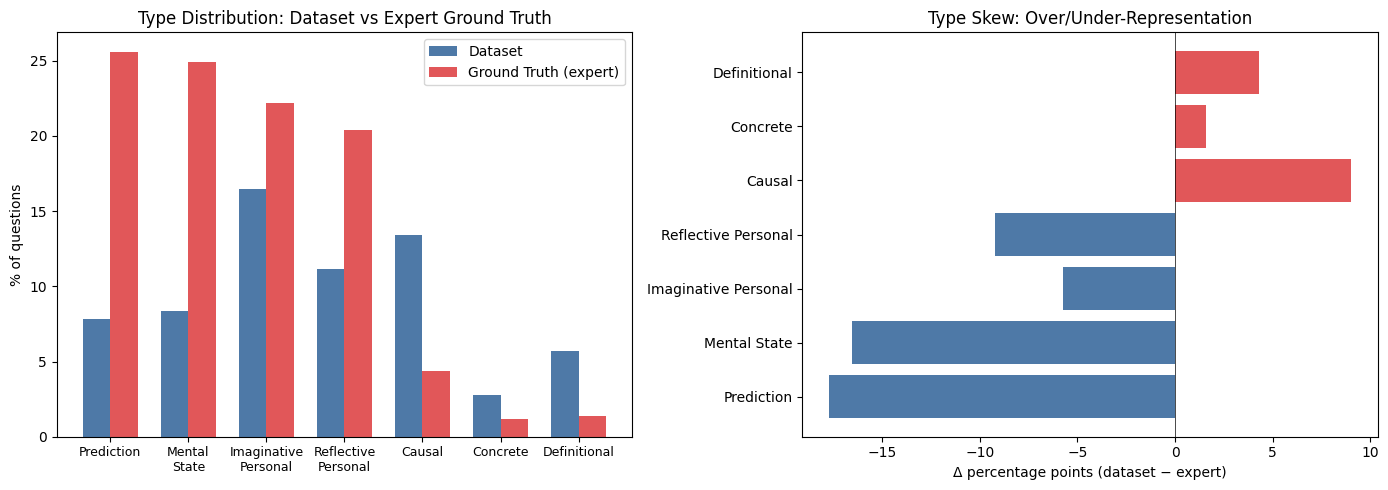

Type                        Count       %    GT%    Delta
--------------------------------------------------------
Prediction                  8,662    7.8%  25.6%   -17.8pp
Mental State                9,194    8.3%  24.9%   -16.6pp
Imaginative Personal       18,171   16.5%  22.2%    -5.7pp
Reflective Personal        12,319   11.2%  20.4%    -9.2pp
Causal                     14,840   13.4%   4.4%    +9.0pp
Concrete                    3,052    2.8%   1.2%    +1.6pp
Definitional                6,289    5.7%   1.4%    +4.3pp
Unclear                    37,885   34.3%   0.0%   +34.3pp


In [42]:
# Ground truth from 3 hand-labeled books (1,169 questions, 33 pages)
GT = {'Prediction': 25.6, 'Mental State': 24.9, 'Imaginative Personal': 22.2,
      'Reflective Personal': 20.4, 'Causal': 4.4, 'Definitional': 1.4, 'Concrete': 1.2}

TYPES = ['Prediction', 'Mental State', 'Imaginative Personal',
         'Reflective Personal', 'Causal', 'Concrete', 'Definitional', 'Unclear']

type_counts = Counter(d['pred_type'] for d in data)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: dataset distribution
types_plot = TYPES[:7]  # exclude Unclear for comparison
dataset_pcts = [type_counts.get(t, 0) / N * 100 for t in types_plot]
gt_pcts = [GT.get(t, 0) for t in types_plot]

x = np.arange(len(types_plot))
w = 0.35
axes[0].bar(x - w/2, dataset_pcts, w, label='Dataset', color='#4e79a7')
axes[0].bar(x + w/2, gt_pcts, w, label='Ground Truth (expert)', color='#e15759')
axes[0].set_xticks(x)
axes[0].set_xticklabels([t.replace(' ', '\n') for t in types_plot], fontsize=9)
axes[0].set_ylabel('% of questions')
axes[0].set_title('Type Distribution: Dataset vs Expert Ground Truth')
axes[0].legend()

# Right: delta
deltas = [d - g for d, g in zip(dataset_pcts, gt_pcts)]
colors = ['#e15759' if d > 0 else '#4e79a7' for d in deltas]
axes[1].barh(types_plot, deltas, color=colors)
axes[1].set_xlabel('Δ percentage points (dataset − expert)')
axes[1].set_title('Type Skew: Over/Under-Representation')
axes[1].axvline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

# Table
print(f"{'Type':25s} {'Count':>7s} {'%':>7s} {'GT%':>6s} {'Delta':>8s}")
print('-' * 56)
for t in TYPES:
    c = type_counts.get(t, 0)
    pct = c / N * 100
    gt = GT.get(t, 0)
    delta = pct - gt
    print(f"{t:25s} {c:7,d} {pct:6.1f}% {gt:5.1f}% {delta:+7.1f}pp")

### Type Distribution by Source (Synthetic vs Gold)

Separating synthetic and gold questions reveals whether the type skew is introduced by GPT-o3's generation tendencies or is inherent to the books. If gold questions match the expert ground truth distribution but synthetic questions are skewed, the bias is clearly an artifact of the generation process.

This matters for the ECO story: the training data may arrive *pre-collapsed* before SFT even touches it. Standard NLL training will then amplify whatever imbalance already exists, because the majority type gets more gradient signal per step.

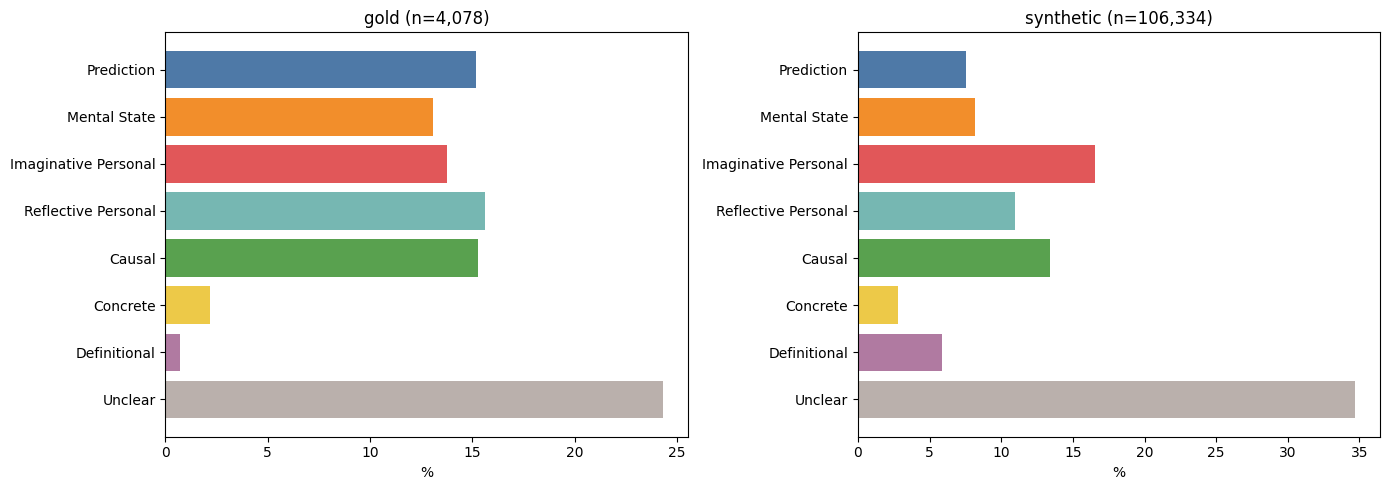

In [43]:
fig, axes = plt.subplots(1, len(sources), figsize=(7 * len(sources), 5), squeeze=False)

TYPE_COLORS = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2',
               '#59a14f', '#edc948', '#b07aa1', '#bab0ac']

for i, src in enumerate(sorted(sources.keys())):
    subset = [d for d in data if d.get('source') == src]
    n_src = len(subset)
    tc = Counter(d['pred_type'] for d in subset)
    pcts = [tc.get(t, 0) / n_src * 100 for t in TYPES]

    axes[0][i].barh(TYPES[::-1], pcts[::-1], color=TYPE_COLORS[::-1])
    axes[0][i].set_title(f'{src} (n={n_src:,})')
    axes[0][i].set_xlabel('%')

plt.tight_layout()
plt.show()

GPT is much more likely to produce "unclear". It was specifically asked to be creative, so this makes sense that some question types just won't fit cleanly.

What is clear, is that it already has a strong skew towards "Imaginitive Personal" over most other types, where the gold set is much more evenly distributed over the 5 major types.

## 3. Per-Page Statistics

Each page acts as a potential equivalence set for ECO - all questions for a given page are valid outputs for that page's image input. Two things matter:

1. **Questions per page**: Pages need enough questions (≥5 minimum, ideally ≥10) for the ECO variance penalty to be meaningful. Variance computed from 2 log-probs is noise, not signal.

2. **Type diversity per page**: Even if a page has 20 questions, if they're all Causal, there's no functional diversity to preserve. We want pages where multiple question types naturally co-occur.

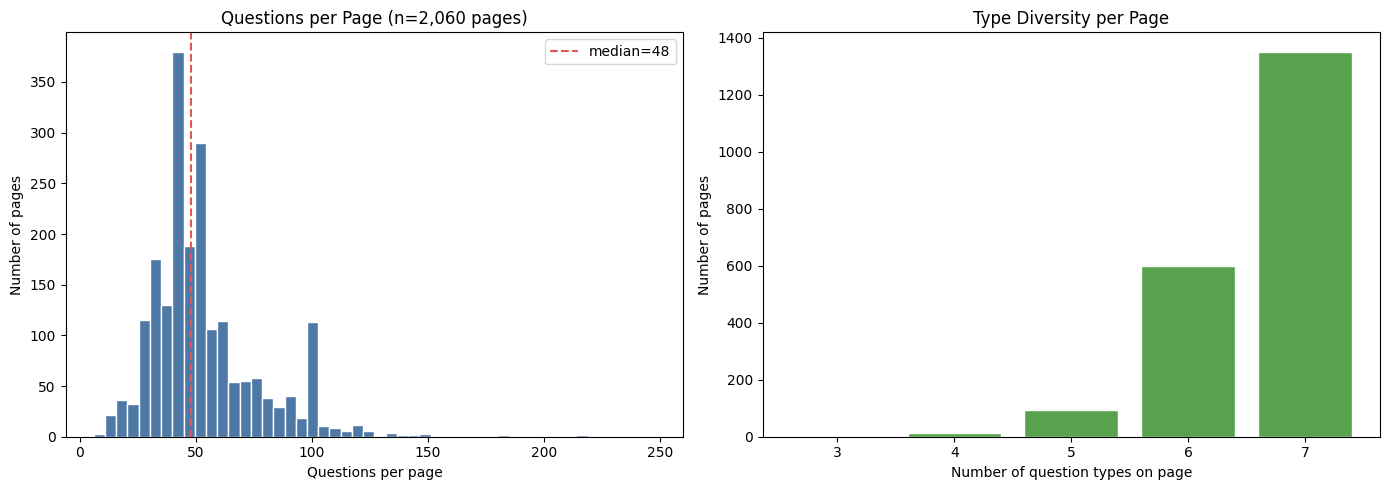

Questions per page: min=6, max=248, mean=53.6, median=48
Type diversity:     min=3, max=7, mean=6.6


In [44]:
page_data = defaultdict(list)
for d in data:
    page_data[d['page_id']].append(d)

page_stats = []
for pid, qs in page_data.items():
    types_on_page = Counter(q['pred_type'] for q in qs)
    n_types = len([t for t in TYPES[:7] if types_on_page.get(t, 0) > 0])
    page_stats.append({
        'page_id': pid,
        'book': qs[0]['book'],
        'n_questions': len(qs),
        'n_types': n_types,
        'type_counts': dict(types_on_page),
        'has_gold': any(q.get('quality') == 1 for q in qs),
        'n_gold': sum(1 for q in qs if q.get('quality') == 1),
    })

n_qs = [p['n_questions'] for p in page_stats]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: questions per page histogram
axes[0].hist(n_qs, bins=50, color='#4e79a7', edgecolor='white')
axes[0].set_xlabel('Questions per page')
axes[0].set_ylabel('Number of pages')
axes[0].set_title(f'Questions per Page (n={len(page_stats):,} pages)')
axes[0].axvline(np.median(n_qs), color='#e15759', linestyle='--', label=f'median={np.median(n_qs):.0f}')
axes[0].legend()

# Right: type diversity per page
n_types_list = [p['n_types'] for p in page_stats]
type_counts_hist = Counter(n_types_list)
xs = sorted(type_counts_hist.keys())
axes[1].bar(xs, [type_counts_hist[x] for x in xs], color='#59a14f', edgecolor='white')
axes[1].set_xlabel('Number of question types on page')
axes[1].set_ylabel('Number of pages')
axes[1].set_title('Type Diversity per Page')

plt.tight_layout()
plt.show()

print(f"Questions per page: min={min(n_qs)}, max={max(n_qs)}, mean={np.mean(n_qs):.1f}, median={np.median(n_qs):.0f}")
print(f"Type diversity:     min={min(n_types_list)}, max={max(n_types_list)}, mean={np.mean(n_types_list):.1f}")

### Equivalence Set Viability for ECO

For the collision sweep and ECO training, we need pages with enough questions to create meaningful within-batch collisions (multiple questions from the same page appearing in one gradient step) and meaningful variance penalties (ECO's coverage term computed over multiple log-probs).

Key thresholds:
- **≥5 questions**: Minimum for ECO's variance penalty to be non-degenerate
- **≥10 questions**: Comfortable for collision experiments (enough to partially fill batches)
- **≥20 questions**: Rich equivalence sets approaching the ~35/page expert baseline

Pages below the threshold still contribute to standard SFT training — they just won't have the ECO coverage term applied (variance over 1–2 items is meaningless).

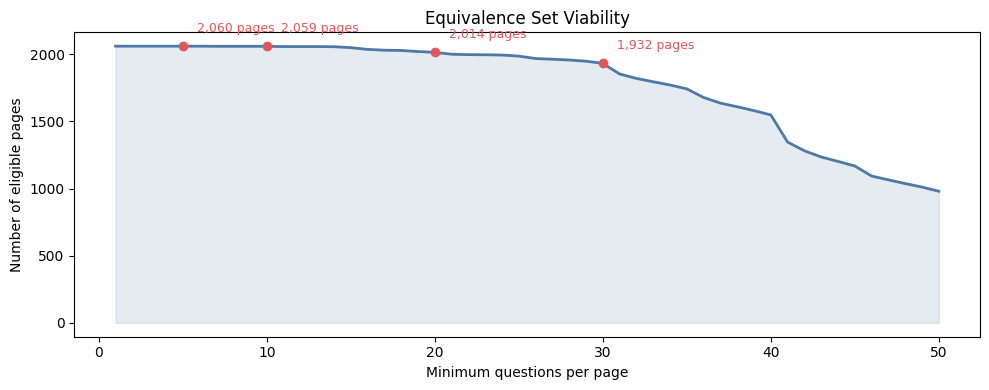

Viability summary:
  >=  5 questions: 2,060 pages (100.0%) — avg 6.6 types
  >= 10 questions: 2,059 pages (100.0%) — avg 6.6 types
  >= 15 questions: 2,049 pages (99.5%) — avg 6.6 types
  >= 20 questions: 2,014 pages (97.8%) — avg 6.6 types
  >= 30 questions: 1,932 pages (93.8%) — avg 6.7 types

Pages with ≥1 gold question: 120
  avg questions on gold pages: 42.4
  avg gold questions per gold page: 34.0


In [45]:
thresholds = list(range(1, 51))
counts_at = [sum(1 for p in page_stats if p['n_questions'] >= t) for t in thresholds]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(thresholds, counts_at, color='#4e79a7', linewidth=2)
ax.fill_between(thresholds, counts_at, alpha=0.15, color='#4e79a7')
ax.set_xlabel('Minimum questions per page')
ax.set_ylabel('Number of eligible pages')
ax.set_title('Equivalence Set Viability')

# Mark key thresholds
for t in [5, 10, 20, 30]:
    c = sum(1 for p in page_stats if p['n_questions'] >= t)
    ax.annotate(f'{c:,} pages', (t, c), textcoords='offset points',
                xytext=(10, 10), fontsize=9, color='#e15759')
    ax.plot(t, c, 'o', color='#e15759', markersize=6)

plt.tight_layout()
plt.show()

print("Viability summary:")
for t in [5, 10, 15, 20, 30]:
    eligible = [p for p in page_stats if p['n_questions'] >= t]
    if eligible:
        avg_types = np.mean([p['n_types'] for p in eligible])
        print(f"  >= {t:2d} questions: {len(eligible):5,d} pages ({len(eligible)/len(page_stats)*100:.1f}%) — avg {avg_types:.1f} types")

gold_pages = [p for p in page_stats if p['has_gold']]
print(f"\nPages with ≥1 gold question: {len(gold_pages):,}")
if gold_pages:
    print(f"  avg questions on gold pages: {np.mean([p['n_questions'] for p in gold_pages]):.1f}")
    print(f"  avg gold questions per gold page: {np.mean([p['n_gold'] for p in gold_pages]):.1f}")

### Type Co-occurrence (pages with ≥5 questions)

This heatmap shows how often each pair of question types appears together on the same page. High co-occurrence across many types means pages naturally contain diverse question sets — exactly the structure ECO needs.

If certain types almost never co-occur (e.g., Definitional only appears on vocabulary-heavy pages), ECO's coverage term won't help those types because they aren't in the same equivalence sets. Pages where many types co-occur are the ideal ECO training examples.

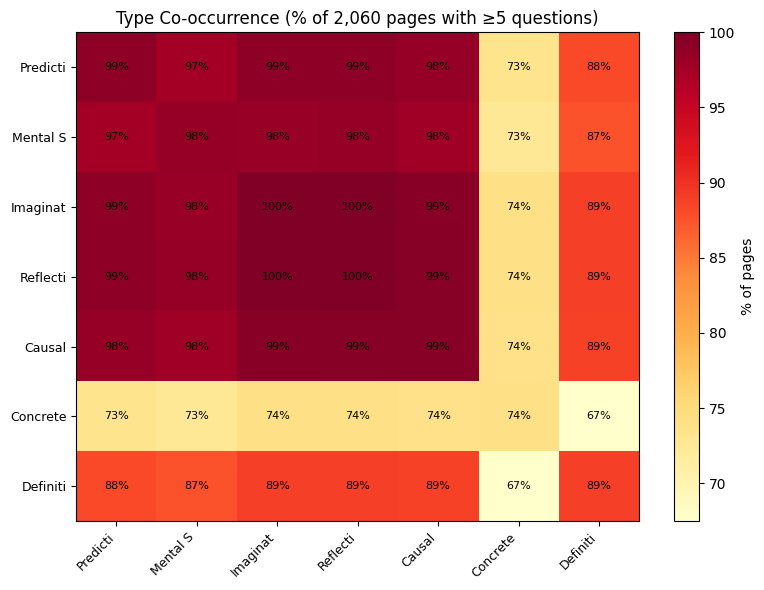

Type presence on pages with ≥5 questions:
  Prediction               :  2038/2060 (98.9%)
  Mental State             :  2027/2060 (98.4%)
  Imaginative Personal     :  2058/2060 (99.9%)
  Reflective Personal      :  2060/2060 (100.0%)
  Causal                   :  2048/2060 (99.4%)
  Concrete                 :  1526/2060 (74.1%)
  Definitional             :  1830/2060 (88.8%)


In [46]:
eligible = [p for p in page_stats if p['n_questions'] >= 5]
n_elig = len(eligible)

# Co-occurrence matrix
types7 = TYPES[:7]
cooccur = np.zeros((7, 7))
presence = np.zeros(7)

for p in eligible:
    present = [1 if p['type_counts'].get(t, 0) > 0 else 0 for t in types7]
    for i in range(7):
        if present[i]:
            presence[i] += 1
            for j in range(7):
                if present[j]:
                    cooccur[i][j] += 1

# Normalize to conditional probability
cooccur_pct = cooccur / n_elig * 100

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cooccur_pct, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(7))
ax.set_yticks(range(7))
short = [t[:8] for t in types7]
ax.set_xticklabels(short, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(short, fontsize=9)
for i in range(7):
    for j in range(7):
        ax.text(j, i, f'{cooccur_pct[i][j]:.0f}%', ha='center', va='center', fontsize=8)
ax.set_title(f'Type Co-occurrence (% of {n_elig:,} pages with ≥5 questions)')
plt.colorbar(im, label='% of pages')
plt.tight_layout()
plt.show()

print("Type presence on pages with ≥5 questions:")
for i, t in enumerate(types7):
    print(f"  {t:25s}: {int(presence[i]):5d}/{n_elig} ({presence[i]/n_elig*100:.1f}%)")

## 4. Analyzing Question Patterns

This checks for the surface-level signatures that define our question types. It serves two purposes:

1. **Classifier sanity check**: "Has 'If yes...If no'" should roughly match Reflective Personal + Definitional counts; "Has 'would you'" should roughly match Imaginative Personal. Mismatches reveal classifier bugs.

2. **Multi-part question prevalence**: The three-part structured questions (Reflective Personal, Definitional) are the most pedagogically distinctive types. They're also the hardest for a model to generate because they require a specific template (question + "If yes, [elaboration]" + "If no, [alternative]"). If these are rare in training data, NLL sharpening will crush them first — making them the poster child for ECO's value proposition.

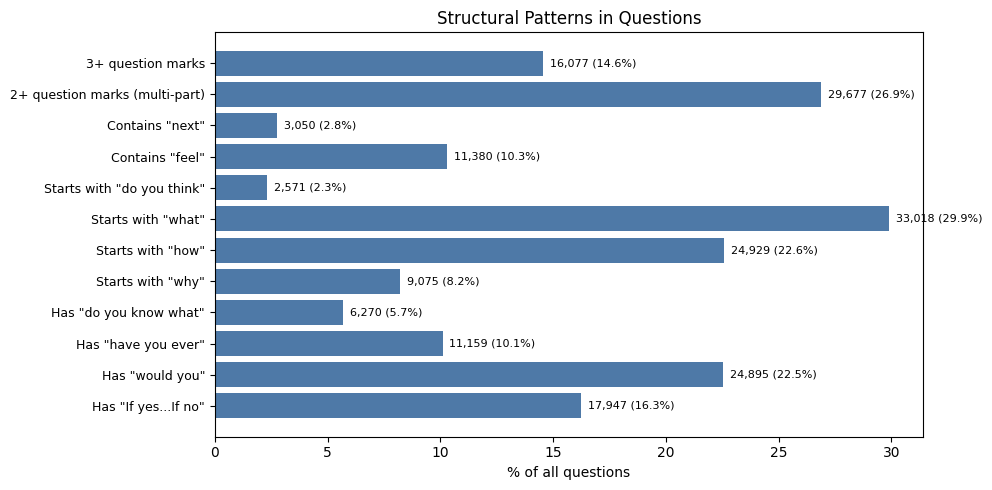

In [47]:
patterns = {
    'Has "If yes...If no"': lambda q: 'if yes' in q.lower() and 'if no' in q.lower(),
    'Has "would you"': lambda q: bool(re.search(r'\bwould you\b', q.lower())),
    'Has "have you ever"': lambda q: bool(re.search(r'have you ever', q.lower())),
    'Has "do you know what"': lambda q: bool(re.search(r'do you know what', q.lower())),
    'Starts with "why"': lambda q: q.lower().strip().startswith('why'),
    'Starts with "how"': lambda q: q.lower().strip().startswith('how'),
    'Starts with "what"': lambda q: q.lower().strip().startswith('what'),
    'Starts with "do you think"': lambda q: q.lower().strip().startswith('do you think'),
    'Contains "feel"': lambda q: bool(re.search(r'\bfeel\b', q.lower())),
    'Contains "next"': lambda q: bool(re.search(r'\bnext\b', q.lower())),
    '2+ question marks (multi-part)': lambda q: q.count('?') >= 2,
    '3+ question marks': lambda q: q.count('?') >= 3,
}

labels, counts = [], []
for label, fn in patterns.items():
    c = sum(1 for d in data if fn(d['question']))
    labels.append(label)
    counts.append(c)

fig, ax = plt.subplots(figsize=(10, 5))
y = range(len(labels))
ax.barh(y, [c/N*100 for c in counts], color='#4e79a7')
ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel('% of all questions')
ax.set_title('Structural Patterns in Questions')
for i, c in enumerate(counts):
    ax.text(c/N*100 + 0.3, i, f'{c:,} ({c/N*100:.1f}%)', va='center', fontsize=8)
plt.tight_layout()
plt.show()

### Question Length by Type

Question length is a rough proxy for structural complexity. We expect:
- **Reflective Personal** and **Definitional** to be longest (three-part structure with conditional branches)
- **Concrete** to be shortest (simple observational questions)
- **Causal** and **Prediction** somewhere in between

If the model collapses toward shorter questions during training, that's another signal of diversity loss — structurally complex types are being dropped in favor of simpler formulations. We can track mean generation length across training checkpoints as a complementary diversity metric.

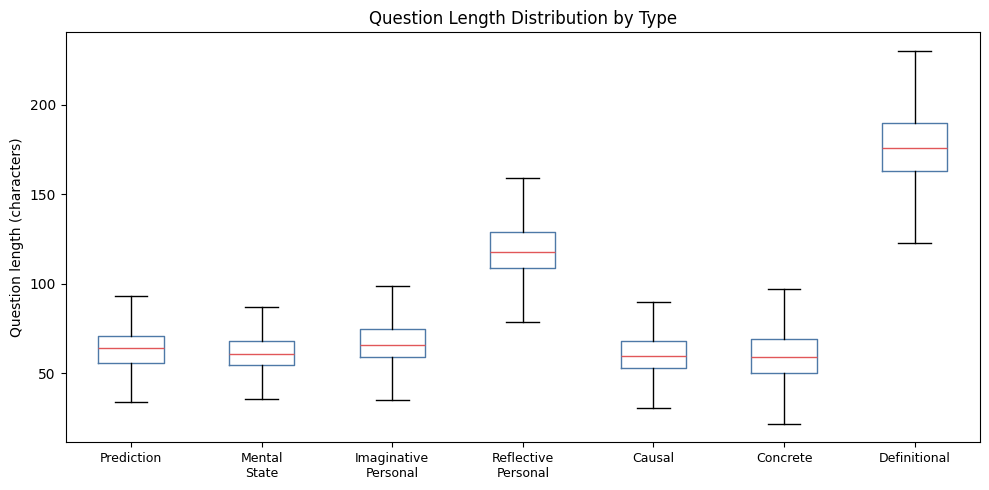

Type                        Mean  Median    P90
------------------------------------------------
Prediction                   64     64     78
Mental State                 62     61     75
Imaginative Personal         68     66     83
Reflective Personal         119    118    140
Causal                       60     60     75
Concrete                     60     59     79
Definitional                177    176    204


In [48]:
fig, ax = plt.subplots(figsize=(10, 5))

type_lens = {}
for t in TYPES[:7]:
    lens = [len(d['question']) for d in data if d['pred_type'] == t]
    if lens:
        type_lens[t] = lens

positions = range(len(type_lens))
ax.boxplot(type_lens.values(), positions=positions, vert=True, showfliers=False,
           boxprops=dict(color='#4e79a7'), medianprops=dict(color='#e15759'))
ax.set_xticks(positions)
ax.set_xticklabels([t.replace(' ', '\n') for t in type_lens.keys()], fontsize=9)
ax.set_ylabel('Question length (characters)')
ax.set_title('Question Length Distribution by Type')
plt.tight_layout()
plt.show()

print(f"{'Type':25s} {'Mean':>6s} {'Median':>7s} {'P90':>6s}")
print('-' * 48)
for t, lens in type_lens.items():
    lens.sort()
    print(f"{t:25s} {np.mean(lens):5.0f} {np.median(lens):6.0f} {lens[int(len(lens)*0.9)]:6.0f}")

## 5. Book-Level Summary

Are some books much more question-rich than others? Is gold coverage spread across the collection or concentrated in a few books? This helps identify whether the dataset is dominated by a few large books (which could bias training toward certain genres or illustration styles) and whether our gold signal is representative.

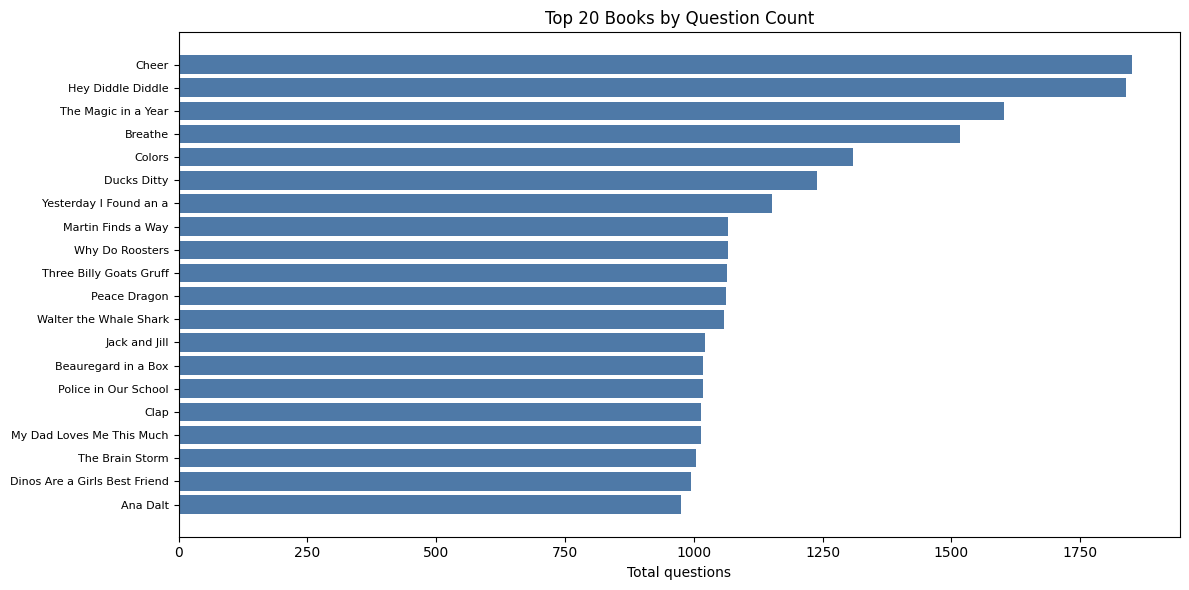

Book                                        Qs  Pgs   Q/P Gold
--------------------------------------------------------------
Cheer                                     1851   34  54.4    0
Hey Diddle Diddle                         1839   36  51.1    0
The Magic in a Year                       1601   21  76.2  695
Breathe                                   1516   20  75.8  744
Colors                                    1309   25  52.4    0
Ducks Ditty                               1240   23  53.9    0
Yesterday I Found an a                    1151   19  60.6    0
Martin Finds a Way                        1067   19  56.2    0
Why Do Roosters                           1066   20  53.3    0
Three Billy Goats Gruff                   1065   17  62.6    0
Peace Dragon                              1063   16  66.4    0
Walter the Whale Shark                    1059   18  58.8    0
Jack and Jill                             1021   20  51.0    0
Beauregard in a Box                       1018   17  59

In [49]:
book_stats = defaultdict(lambda: {'n': 0, 'pages': set(), 'types': Counter(), 'gold': 0})
for d in data:
    b = book_stats[d['book']]
    b['n'] += 1
    b['pages'].add(d['page_id'])
    b['types'][d['pred_type']] += 1
    if d.get('quality') == 1:
        b['gold'] += 1

sorted_books = sorted(book_stats.items(), key=lambda x: -x[1]['n'])

# Top 20 plot
top20 = sorted_books[:20]
fig, ax = plt.subplots(figsize=(12, 6))
book_names = [name[:30] for name, _ in top20]
book_qs = [stats['n'] for _, stats in top20]
ax.barh(range(len(top20)), book_qs, color='#4e79a7')
ax.set_yticks(range(len(top20)))
ax.set_yticklabels(book_names, fontsize=8)
ax.set_xlabel('Total questions')
ax.set_title('Top 20 Books by Question Count')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(f"{'Book':40s} {'Qs':>5s} {'Pgs':>4s} {'Q/P':>5s} {'Gold':>4s}")
print('-' * 62)
for name, stats in sorted_books[:20]:
    qpp = stats['n'] / len(stats['pages'])
    print(f"{name[:38]:40s} {stats['n']:5d} {len(stats['pages']):4d} {qpp:5.1f} {stats['gold']:4d}")

## Summary and Saving

Key numbers that feed directly into experiment design:
- **Eligible pages at various thresholds** → determines how many equivalence sets ECO can operate on
- **Most over/under-represented types** → predicts which types NLL sharpening will amplify/eliminate
- **Average type diversity** → baseline for measuring whether ECO preserves diversity that SFT destroys

In [50]:
eligible_10 = [p for p in page_stats if p['n_questions'] >= 10]
eligible_20 = [p for p in page_stats if p['n_questions'] >= 20]

print(f"Pages with ≥10 questions: {len(eligible_10):,}")
print(f"Pages with ≥20 questions: {len(eligible_20):,}")

# Type imbalance
type_pcts = {t: type_counts.get(t, 0) / N * 100 for t in TYPES[:7]}
most_over = max(TYPES[:7], key=lambda t: type_pcts[t] - GT.get(t, 0))
most_under = min(TYPES[:7], key=lambda t: type_pcts[t] - GT.get(t, 0))
print(f"\nMost over-represented:  {most_over} ({type_pcts[most_over]:.1f}% vs {GT[most_over]:.1f}% GT)")
print(f"Most under-represented: {most_under} ({type_pcts[most_under]:.1f}% vs {GT[most_under]:.1f}% GT)")

unclear_pct = type_counts.get('Unclear', 0) / N * 100
print(f"Unclear (unclassified): {unclear_pct:.1f}%")

print(f"\nAvg questions per page: {np.mean(n_qs):.1f}")
print(f"Avg type diversity per page (≥10 qs): {np.mean([p['n_types'] for p in eligible_10]):.1f}")

Pages with ≥10 questions: 2,059
Pages with ≥20 questions: 2,014

Most over-represented:  Causal (13.4% vs 4.4% GT)
Most under-represented: Prediction (7.8% vs 25.6% GT)
Unclear (unclassified): 34.3%

Avg questions per page: 53.6
Avg type diversity per page (≥10 qs): 6.6


## Save Classified Data

Writes the full dataset with `pred_type` labels added. These labels are used during evaluation in the collision sweep and ECO experiments: at each checkpoint, we generate questions from held-out pages, classify them, and compare the type distribution to this baseline to track how training shifts it.

In [51]:
out_path = DATA_PATH.replace('.jsonl', '_classified.jsonl')
with open(out_path, 'w') as f:
    for d in data:
        f.write(json.dumps(d) + '\n')
print(f"Saved classified data to {out_path}")

Saved classified data to train_classified.jsonl
